<a id='top'></a>
Info:

- **Please run cells in order, otherwise analysis *WILL* be inaccurate.**
- Some expalinations are provided in `Supplementary content` section.
- Links to data source is given, which goes thorugh internet. But data is avaiable locally in `data` folder at root.
- There are hyperlinks to different section of the notebooks as well, which does not go through internet. Intended for quick navigation through the notebook.
- Long visualization codes are functionalized and put at the setup section. Functions used for analysis are placed near from where they are called.
- All imports needed for the analysis is in one code cell block.
- Codes are written from scratch, with the help of a lot of web searching and going through documentation of numpy, pandas, and scikit-learn, to name a few.
- It takes around 15 seconds to run all the cells of the notebook.
- Code blocks are formatted conforming to [*pep8*](https://peps.python.org/pep-0008/) standard.
___

# Maternal Health Risk Assessment

# Motivating the Dataset Choice

The high prevalence of birth complications in rural Bangladesh is a critical public health concern. According to [World Bank Data](https://data.worldbank.org/indicator/SH.STA.MMRT?locations=BD), Bangladesh faces a maternal mortality rate of approximately 173 per 100,000 live births. This significantly exceeds the Sustainable Development Goal (SDG) target of reducing the global maternal mortality ratio to 70 by 2030. The dataset selection process was driven by a pressing need to address maternal health challenges in rural Bangladesh. With alarming rates of maternal mortality and significant barriers to healthcare access, the country is lagging behind global targets. 

The dataset, sourced from the UCI Machine Learning Repository titled [Maternal Health Risk Data Set](https://archive.ics.uci.edu/ml/datasets/Maternal+Health+Risk+Data+Set), offers insights from various healthcare facilities and maternal health centers across rural Bangladesh. By analyzing this data, we aim to identify risk factors and develop a model to categorize expecting mothers into different risk clusters. This approach can inform targeted interventions, ensuring that vulnerable women receive the necessary care and support during pregnancy, ultimately reducing maternal mortality rates.

# The Analysis Goal : Categorizing expecting mothers in Different Risk Clusters

The goal of this notebook analysis is to do some preliminary data analysis to understand the data (data profiling), data visualization to get insights and preparing the data for `Logistic Regression` taught in `CSE-6040` and lastly using `scikit-learn`'s own implementation of [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) library to cluster the sample data points.

This initial analysis could pave the way for a model capable of classifying individual women into these risk clusters. Such a model could then be used to prioritize additional care for high-risk mothers during pregnancy, potentially leading to a decrease in childbirth mortality rates.

# Dataset Description

- Data Set Information:

`Age`, Systolic Blood Pressure as `SystolicBP`, Diastolic BP as `DiastolicBP`, Blood Sugar as `BS`, Body Temperature as `BodyTemp`, `HeartRate` and `RiskLevel`. All these are the responsible and significant risk factors for maternal mortality, which is one of the main concern of [Sustainable Development Goals](https://sdgs.un.org/goals) of [United Nations](https://en.wikipedia.org/wiki/United_Nations).

<br>
- Attribute Information:
    - Independent variables (a.k.a. predictor)<sup>1</sup>
        1. Age: Any ages in years when a women during pregnant.
        2. SystolicBP: Upper value of Blood Pressure in mmHg, another significant attribute during pregnancy.
        3. DiastolicBP: Lower value of Blood Pressure in mmHg, another significant attribute during pregnancy.
        4. BS: Blood glucose levels is in terms of a molar concentration, mmol/L.
        5. HeartRate: A normal resting heart rate in beats per minute.
<br>
<br>
    - Dependent variable (a.k.a. goal)<sup>2</sup>
        6. Risk Level: Predicted Risk Intensity Level during pregnancy considering the other predictor attributes.



<br>
Note:
1. The dependent variable is the variable about which predictions or explanations are being sought.
2. Independent variables are those that are used to generate predictions about or to account for the variation in the dependent variable.

# Setup
Run the following code cell to load the utilities and functions used for analysis and visualization 

In [1]:
# data manipulation
import pandas as pd
import numpy as np
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
# ML
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [2]:
# functions used for visualizations are in this cell block


def visuals(q: str, title: str, col: str = "Age", palette="hls") -> None:
    """
    Creates a horizontal bar chart visualization based on a query and column selection.

    Args:
        q (str): A string representing the query to filter the data in 'df' DataFrame.
        title (str): The title to display for the chart.
        col (str, optional): The column name from 'df' to use for the x-axis (default: "Age").

    Returns:
        None: This function does not return any value, it creates and displays the chart.
    """
    # Create the seaborn barplot
    ax = sns.barplot(
        y="index",
        x="Count",
        data=df.query(q)[col].value_counts().sort_index().reset_index(
            name="Count"),
        orient="h",
        palette=palette,
    )

    # Add bar labels with percentage formatting
    for container in ax.containers:
        ax.bar_label(container, fmt="%.f", label_type="edge", padding=2)

    # Customize plot elements
    plt.title(title)
    plt.xlabel("")
    plt.ylabel(col)
    plt.xticks([])
    sns.despine()
    plt.tight_layout()
    plt.show()


def plotPerColumnDistribution(df: pd.DataFrame,
                              nGraphShown: int,
                              nGraphPerRow: int,
                              figsize: tuple = (3, 2),
                              x_rotation: int = 90,
                              title_fontsize: int = 12,
                              show_x_lable: bool = False,
                              numerical_columns_bar_color: str = 'g',
                              categorical_columns_bar_color: str = 'purple',
                              kde_color: str = 'r',
                              debug: bool = False) -> None:
    """
    Creates a grid of subplots to visualize the distribution of each column in a pandas DataFrame.

    Args:
        df (pd.DataFrame): The DataFrame containing the data for visualization.
        nGraphShown (int, optional): The maximum number of columns to display. 
        nGraphPerRow (int, optional): The number of graphs to display per row in the grid.
        figsize (tuple, optional): The desired figure size in inches. Defaults to (3, 2). 
                                    Adjust based on the number of columns.
        x_rotation (int, optional): The rotation angle for x-axis labels (in degrees). 
                                    Defaults to 90 for better readability with categorical data.
        title_fontsize (int, optional): The font size for plot titles. Defaults to 12.
        show_x_lable (bool, optional): Whether to display the x-axis label ("values"). Defaults to False.
        numerical_columns_bar_color (str, optional): The color for histogram bars of numerical columns. 
                                    Defaults to 'g' (green).
        categorical_columns_bar_color (str, optional): The color for bars of categorical columns. Defaults to 'purple'.
        kde_color (str, optional): The color for the KDE line in numerical column plots. Defaults to 'r' (red).
        debug (bool,  optional): Enables printing of intermediate values for debugging purposes. Defaults to False.

    Returns:
        None: This function does not return a value, it creates and displays the plot grid.

    Note:
        - This function attempts to automatically detect categorical columns based on the number of unique values.
        - Columns with a very high number of unique values (more than 50) are excluded for performance reasons.
    """
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]]
    if debug:
        print(f"{df = }")

    nRow, nCol = df.shape
    if debug:
        print(f"{nRow = }, {nCol = }")

    columnNames = list(df)
    if debug:
        print(f"{columnNames = }")

    nGraphRow = round((nCol + nGraphPerRow - 1) /
                      nGraphPerRow)  # this may be a roblemetic line
    if debug:
        print(f"{nGraphRow = }")

    width, height = figsize  # in inches
    plt.figure(num=None,
               figsize=(width * nGraphPerRow, height * nGraphRow),
               dpi=80,
               facecolor='w',
               edgecolor='k')

    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if debug:
            display(f"{columnDf = }")

        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar(
                alpha=.5,
                color=categorical_columns_bar_color,
                title=f'{columnNames[i]}\n(Categorical - column {i})',
                fontsize=title_fontsize)
            if show_x_lable:
                plt.xlabel('values')
            plt.ylabel('count')
        else:
            ax = columnDf.hist(alpha=.5, color=numerical_columns_bar_color)
            if show_x_lable:
                plt.xlabel('values')
            plt.ylabel('count')
            ax1 = ax.twinx()
            columnDf.plot.kde(ax=ax1, color=kde_color)
            ax.grid()
            plt.title(f'{columnNames[i]}\n(Numeric - column {i})',
                      fontsize=title_fontsize)
            plt.ylabel('density')

        plt.xticks(rotation=x_rotation)
    plt.tight_layout()
    plt.show()


def hist_with_kde(s: pd.Series,
                  figsize: tuple = (3, 2),
                  bar_color: str = 'g',
                  kde_color: str = 'r') -> None:
    """
    Creates a combined histogram and KDE plot for a pandas Series.

    Args:
        s (pd.Series): The pandas Series to create the plot for.
        figsize (tuple, optional): The desired figure size in inches. Defaults to (3, 2).
        bar_color (str, optional): The color for the histogram bars. Defaults to 'g' (green).
        kde_color (str, optional): The color for the KDE line. Defaults to 'r' (red).

    Returns:
        None: This function does not return a value, it creates and displays the plot.
    """
    # Create a figure and primary axis for the histogram
    fig, ax = plt.subplots(figsize=figsize)
    # Create the histogram with user-specified color and semi-transparent fill
    ax = s.hist(alpha=.5, color=bar_color)
    plt.xlabel('Values')
    plt.ylabel('Count')
    # Create a twin axis for the KDE plot
    ax1 = ax.twinx()
    # Plot the KDE on the twin axis with user-specified color
    s.plot.kde(ax=ax1, color=kde_color)
    # Add gridlines to the primary axis
    ax.grid()
    # Set plot title using the Series name
    plt.title(f'{s.name}', fontsize=20)
    # Adjust spacing to prevent overlapping elements
    plt.tight_layout()
    # Display the plot
    plt.show()


def report(X_test, y_test, y_pred, model) -> None:
    """
    Generates and displays a confusion matrix and classification report for a classification model.

    Args:
      X_test (np.ndarray): The test data features.
      y_test (np.ndarray): The true labels for the test data.
      y_pred (np.ndarray): The predicted labels from the classification model.
      model (sklearn model): The trained classification model.

    Returns:
      None: This function does not return a value.
    """
    from sklearn.metrics import ConfusionMatrixDisplay, classification_report

    # Create and display confusion matrix
    ConfusionMatrixDisplay.from_estimator(
        model,
        X_test,
        y_test,
        cmap="BuPu",
        normalize="true",
    )
    plt.title("Confusion Matrix")
    plt.tight_layout()
    plt.show()

    # Print classification report
    print(classification_report(y_test, y_pred))


def bold_print(s):
    import sys
    return sys.stdout.write("\033[1m" + s + "\033[0m")

# Data OBTAIN and SCRUBBING

[Source](https://archive.ics.uci.edu/ml/datasets/Maternal+Health+Risk+Data+Set): Marzia Ahmed ([Email](ahmed.marzia32@gmail.com)). Institution: Daffodil International University, Dhaka, Bangladesh. 

First load the dataset which is inside the workspace inside `data` folder, named `Maternal Health Risk Data Set.csv`, then try to see if the data contains any anomaly such as duplicates or null values. 

## Load

In [3]:
df = pd.read_csv("./data/Maternal Health Risk Data Set.csv")

In [4]:
# data description
print("Data set contains {} observations and {} attributes.".format(*df.shape))
print(f"""Columns of the dataset: {str(df.columns.to_list())[1:-1]}.""")

nume_cols: list = df.select_dtypes(include="number").columns.to_list()
cate_cols: list = df.select_dtypes(include="object").columns.to_list()
print(f"\t{len(nume_cols)} Numeric column:\t{nume_cols}")
print(f"\t{len(cate_cols)} Categorical column:\t{cate_cols}")

Data set contains 1014 observations and 7 attributes.
Columns of the dataset: 'Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate', 'RiskLevel'.
	6 Numeric column:	['Age', 'SystolicBP', 'DiastolicBP', 'BS', 'BodyTemp', 'HeartRate']
	1 Categorical column:	['RiskLevel']


`RiskLevel` column is the dependent variable.

In [5]:
# data type of each columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1014 entries, 0 to 1013
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Age          1014 non-null   int64  
 1   SystolicBP   1014 non-null   int64  
 2   DiastolicBP  1014 non-null   int64  
 3   BS           1014 non-null   float64
 4   BodyTemp     1014 non-null   float64
 5   HeartRate    1014 non-null   int64  
 6   RiskLevel    1014 non-null   object 
dtypes: float64(2), int64(4), object(1)
memory usage: 55.6+ KB


In [6]:
# lets take a look at 15 randomly chosen observations of the `df`
display(df.sample(15))

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
951,17,85,60,7.5,102.0,86,low risk
615,34,110,70,7.0,98.0,80,high risk
554,55,140,95,19.0,98.0,77,high risk
796,23,130,70,6.8,98.0,78,mid risk
282,45,120,95,7.7,98.0,66,low risk
372,60,120,85,15.0,98.0,60,mid risk
302,48,120,80,11.0,98.0,88,high risk
821,31,120,60,6.1,98.0,76,mid risk
642,50,120,80,7.0,98.0,70,mid risk
961,40,160,100,19.0,98.0,77,high risk


## `NaN` imputation

In [7]:
# check if there is any nulls
df.isna().sum()

Age            0
SystolicBP     0
DiastolicBP    0
BS             0
BodyTemp       0
HeartRate      0
RiskLevel      0
dtype: int64

No Nulls, nothing to impute.

## Statistics

In [8]:
df.describe(include="all").T.infer_objects().style.format(na_rep='', thousands=",", precision=2)

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Age,"1,014.00",,,,29.87,13.47,10.00,19.00,26.00,39.00,70.00
SystolicBP,"1,014.00",,,,113.20,18.40,70.00,100.00,120.00,120.00,160.00
DiastolicBP,"1,014.00",,,,76.46,13.89,49.00,65.00,80.00,90.00,100.00
BS,"1,014.00",,,,8.73,3.29,6.00,6.90,7.50,8.00,19.00
BodyTemp,"1,014.00",,,,98.67,1.37,98.00,98.00,98.00,98.00,103.00
HeartRate,"1,014.00",,,,74.30,8.09,7.00,70.00,76.00,80.00,90.00
RiskLevel,"1,014.00",3.00,low risk,406.00,,,,,,,


Observations:
- `Age`: Large distribution of age range
- `BS`: minimum is 6. All observations have relatively high blood sugar
- `BodyTemp`: smaller range. 
- `HeartRate`: min value does not make sense, also the long tail of kde of that column suggest outliers. Will be explored in Cleaning section

(Passes data sanity check, except `HeartRate`)

> None of them have normal distribution

Which can be observed from following visualization

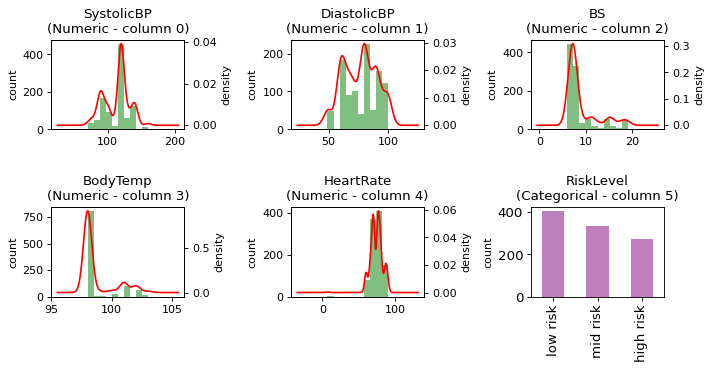

In [9]:
plotPerColumnDistribution(df, len(df.columns), 3)

<a id='duplicates'></a>
## Duplicates 


In [10]:
print(f"Found {df.duplicated().sum()} duplicates.")

Found 562 duplicates.


In [11]:
print("lets look at the duplicate observations")
df[df.duplicated()]

lets look at the duplicate observations


,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
67,19,120,80,7.0,98.0,70,mid risk
72,19,120,80,7.0,98.0,70,mid risk
97,19,120,80,7.0,98.0,70,mid risk
106,50,140,90,15.0,98.0,90,high risk
107,25,140,100,6.8,98.0,80,high risk
...,...,...,...,...,...,...,...
1009,22,120,60,15.0,98.0,80,high risk
1010,55,120,90,18.0,98.0,60,high risk
1011,35,85,60,19.0,98.0,86,high risk
1012,43,120,90,18.0,98.0,70,high risk


Dropping duplicates, as this duplicated data will not be helpful for the regression task. 

This step will be done in Cleaning / Pre-processing [step](#duplicates-code), As we still need to to look at those observations for EDA, where those duplicates are still useful.

# Exploratory Data Analysis - EDA

## `RiskLevel`

,RiskLevel Categories,Percentage
0,low risk,40.04
1,mid risk,33.14
2,high risk,26.82


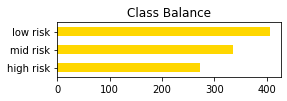

In [12]:
# Class Balance Check of Target variable `RiskLevel`
## Value Counts
display(
    df["RiskLevel"]
    .value_counts(1)
    .apply(lambda x: round(x * 100, 2))
    .to_frame()
    .reset_index()
    .rename(columns={"RiskLevel": "Percentage", "index":"RiskLevel Categories"})
)
# `Matplotlib` Figure
df["RiskLevel"].value_counts()[::-1].plot(
    kind="barh", title="Class Balance", figsize=(4, 1), color="gold"
)
plt.show()

Risk levels are distributed fairly in an uniform manner with the number of high risk being the lowest.

## `Age`

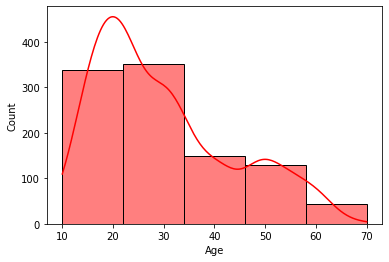

In [13]:
sns.histplot(df['Age'], bins=5, kde=True, color='red')
plt.show()

We can see the age distribution is mostly peaks at the age between 15-25. We can see the distribution of the age from the code cell below.

In [14]:
print(f"Lowest age of pregnancy: {df['Age'].min()} & Highest age of pregnancy: {df['Age'].max()}.")

pd.merge(
    df["Age"]
    .value_counts(1, bins=10)
    .apply(lambda x: round(x * 100, 2))
    .to_frame()
    .sort_index()
    .reset_index().rename(columns={"index":"Age Bins `(start, end]`"}),
    df["Age"]
    .value_counts(bins=10)
    .to_frame()
    .sort_index()
    .reset_index().rename(columns={"index":"Age Bins `(start, end]`"}),
    on="Age Bins `(start, end]`",
).rename(columns={"Age_x": "Percentage", "Age_y": "Counts"})

Lowest age of pregnancy: 10 & Highest age of pregnancy: 70.


,"Age Bins `(start, end]`",Percentage,Counts
0,"(9.939, 16.0]",12.82,130
1,"(16.0, 22.0]",25.05,254
2,"(22.0, 28.0]",15.98,162
3,"(28.0, 34.0]",14.79,150
4,"(34.0, 40.0]",10.16,103
5,"(40.0, 46.0]",4.14,42
6,"(46.0, 52.0]",7.79,79
7,"(52.0, 58.0]",4.93,50
8,"(58.0, 64.0]",3.85,39
9,"(64.0, 70.0]",0.49,5


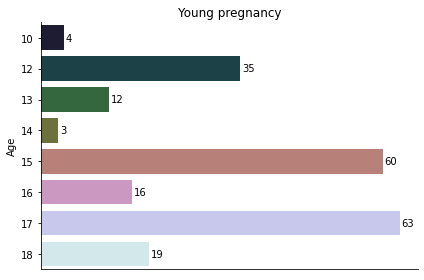

In [15]:
visuals(q="Age <= 18", title="Young pregnancy", palette="cubehelix")

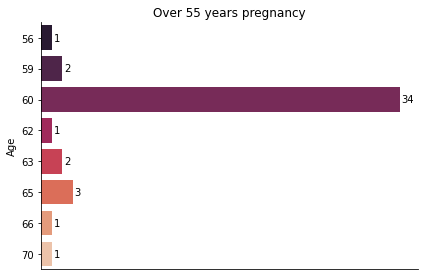

In [16]:
visuals(q="Age > 55", title="Over 55 years pregnancy", palette='rocket')

There are a large portion of teen pregnency, which is understandable given the socio-economic standards of the country. But the amount of obeservations for the elder population needs futher investigation, which is done in the cleaning section of the notebook.

## `BS`

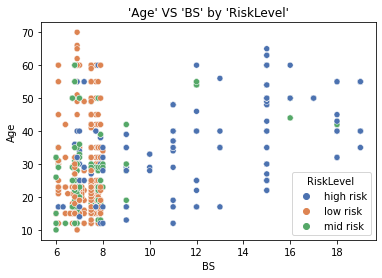

In [17]:
sns.scatterplot(y=df["Age"], x=df["BS"], hue=df["RiskLevel"], palette='deep')
plt.title("'Age' VS 'BS' by 'RiskLevel'")
plt.show()

## `HeartRate`

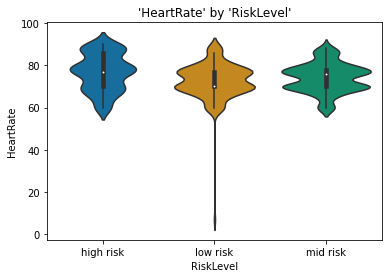

In [18]:
sns.violinplot(data=df, y="HeartRate", x="RiskLevel", palette='colorblind')
plt.title("'HeartRate' by 'RiskLevel'")
plt.show()

From the above two diagrams , we can see a clear distinction where higher Blood Sugar and Heart Rate leads to greater Risk

# Cleaning - SCRUBBING | PRE-PROCESSING DATA

## Categorical remap

As for data cleaning and preparation, the categorical values of RiskLevel column needs to be converted to numerical values where high=1, mid=0, low=0. 

This is done because, the Binomial Logistic Regression needs the dependent variable (which in this case is `RiskLevel`) to be numerical. So we are going to cluster the labels either in 1 or 0.

In [19]:
target_map:dict = {"low risk": 0, "mid risk": 0, "high risk": 1}
df["RiskLevel"] = df["RiskLevel"].map(target_map)

In [20]:
# after re-map
df["RiskLevel"].value_counts().to_frame().reset_index().rename(columns={'index':"RiskLevel", "RiskLevel":"Count"})

,RiskLevel,Count
0,0,742
1,1,272


## Outlier Handling

### `HeartRate`

In [21]:
# lets look at distribution to find out weird values
heart_rate_description: pd.Series = df['HeartRate'].describe(percentiles=[.01, .25, .5, .75])
heart_rate_description

count    1014.000000
mean       74.301775
std         8.088702
min         7.000000
1%         60.000000
25%        70.000000
50%        76.000000
75%        80.000000
max        90.000000
Name: HeartRate, dtype: float64

In [22]:
first_quartile: float = heart_rate_description.loc["1%"]
print(f"{first_quartile = }")

first_quartile = 60.0


In [23]:
# lets look at all values less than 1% quartile
df.query(f"HeartRate < {first_quartile}")

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
499,16,120,75,7.9,98.0,7,0
908,16,120,75,7.9,98.0,7,0


seems like a data entry error, replacing those with `70`.

In [24]:
# index of the erroneous values, used to check `df` after insertion
check_index = df.query(f"HeartRate < {first_quartile}").index
# error value
err_val_HeartRate = df.query(f"HeartRate < {first_quartile}")["HeartRate"].unique()[0]
# insertion
df.loc[df["HeartRate"] == err_val_HeartRate, "HeartRate"] = 70

In [25]:
df.iloc[check_index]

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel
499,16,120,75,7.9,98.0,70,0
908,16,120,75,7.9,98.0,70,0


looks good now.

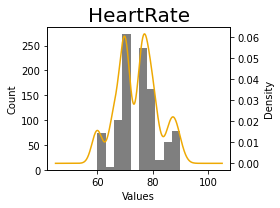

In [26]:
hist_with_kde(df['HeartRate'], figsize=(4,3), bar_color='black', kde_color='#eea904')

### `Age`

In an earlier cell , we saw that there are birth records where age is between 55-70. These records can be termed as outliers or error in input. Reasoning behind this is inspired from [this](https://www.mymenopausecentre.com/gp-resources/fertility-and-the-menopause/) article. Which states that pregnency after 55 is extremenly rare yet we have 45 of such isntances.

Thus we are going to take average of the age values from 30-70 and replace those values with that mean value.

In [27]:
print(
f"""{len(df.loc[(df["Age"] > 55) & (df["Age"] <= 70)])} observations are aged over 55, \
which is {(len(df.loc[(df["Age"] > 55) & (df["Age"] < 70)])/len(df)*100):.2f}% of the data."""
)

45 observations are aged over 55, which is 4.34% of the data.


In [28]:
# get mean age (not rounding the age)
mean_age:float = df.query("30 < Age <= 70")["Age"].mean()
print(f"The mean value of column `Age` between `30 < Age < 70` is: `{mean_age = :.0f}`")

# insert imputed values
df.loc[(df["Age"] > 55) & (df["Age"] <= 70), "Age"] = mean_age

The mean value of column `Age` between `30 < Age < 70` is: `mean_age = 44`


## Creating a new feature '`Preeclampsia`' from '`SystolicBP`' and '`DiastolicBP`'

By combining SystolicBP and DiastolicBP into a single feature representing preeclampsia risk, it can be potentially helpful to capture the interaction between these two blood pressure readings. This interaction might be more informative for the model than separate features.

In [29]:
def preeclampsia(SystolicBP: int, DiastolicBP: int) -> str:
  """
  Preeclampsia and High Blood Pressure During Pregnancy - recode from measures.
  Link: https://www.acog.org/womens-health/faqs/preeclampsia-and-high-blood-pressure-during-pregnancy

  Args:
      SystolicBP (int): pressure against the artery walls when the heart contracts
      DiastolicBP (int): pressure against the artery walls when the heart relaxes between contractions

  Returns:
      str: type of blood pressure.
  """
  if 120 <= SystolicBP < 130 and DiastolicBP < 80:
    return "elevated"
  elif SystolicBP < 130 and DiastolicBP < 80:
    return "normal"
  elif (130 <= SystolicBP < 140) or (80 <= DiastolicBP < 90):
    return "hypertension_1"
  elif SystolicBP >= 140 or DiastolicBP >= 90:
    return "hypertension_2"
  else:
    # Handle potential errors
    return "Err"

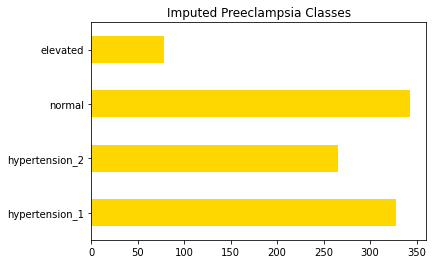

In [30]:
# new feature values distribution
df.apply(lambda x: preeclampsia(x['SystolicBP'], x['DiastolicBP']),
         axis=1).value_counts(sort=False).plot(
             kind='barh', title="Imputed Preeclampsia Classes", color="gold")
plt.show()

In [31]:
# map to convert to numerical values based on severity
# Note: this is a categorical feature that needs to to encoded in numbers to be used in logistic regression
preeclampsia_map: dict = {
    "normal": 0,
    "elevated": 1,
    "hypertension_1": 2,
    "hypertension_2": 3,
}
# appending to DataFrame
df['Preeclampsia'] = df.apply(lambda x: preeclampsia(x['SystolicBP'], x['DiastolicBP']), axis=1).map(preeclampsia_map)

In [32]:
df.groupby(["Preeclampsia", "RiskLevel"]).mean().round(2)

Age  SystolicBP  DiastolicBP     BS  BodyTemp  \
Preeclampsia RiskLevel                                                    
0            0          22.88       91.21        61.13   7.21     98.91   
             1          22.18       91.77        64.25   9.75    100.93   
1            0          26.49      120.00        67.69   6.75     98.35   
             1          30.60      120.00        71.00   9.78     98.40   
2            0          29.06      121.14        79.64   7.90     98.41   
             1          42.06      125.43        82.24  11.88     98.64   
3            0          30.94      118.35        90.79   7.58     98.32   
             1          38.83      137.50        95.87  13.37     98.19   

                        HeartRate  
Preeclampsia RiskLevel             
0            0              75.01  
             1              75.78  
1            0              72.63  
             1              74.00  
2            0              72.85  
             1              76.86  
3            0              72.37  
             1              77.28

Observations:
- Age: The age range appears to be from around 22 to 42 years old. That is expected after outlier handling in the previous step.

- Blood Pressure: 
    - There seems to be a possible correlation between higher age and higher systolic blood pressure.
    - Diastolic blood pressure also shows a potential increase with age.

- Blood Sugar: Blood sugar levels vary across individuals and conditions. 
    - There seems to be a wider range of values in rows (2, 1) and (3, 1). Leading to an understanding that increased blood sugar also has impact on high blood pressure

<a id='duplicates-code'></a>
## Removing Duplicates

As discussed before [here](#duplicates), now dropping duplicate values.

In [33]:
df = df[~df.duplicated()]

In [34]:
# Final DataFrame
df

,Age,SystolicBP,DiastolicBP,BS,BodyTemp,HeartRate,RiskLevel,Preeclampsia
0,25.0,130,80,15.0,98.0,86,1,2
1,35.0,140,90,13.0,98.0,70,1,3
2,29.0,90,70,8.0,100.0,80,1,0
3,30.0,140,85,7.0,98.0,70,1,2
4,35.0,120,60,6.1,98.0,76,0,1
...,...,...,...,...,...,...,...,...
673,12.0,100,50,6.4,98.0,70,0,0
674,15.0,100,60,6.0,98.0,80,0,0
703,15.0,100,49,7.6,98.0,77,0,0
704,12.0,100,50,6.0,98.0,70,0,0


In [35]:
print("Now dataset have {} observations; and still having {} features.".format(*df.shape))

Now dataset have 427 observations; and still having 8 features.


# Logistic Regression

First we will separate the features and the labels (`RiskLevel`). We want to keep a certain amount of data separate, which is going to be used for testing purposes. We will choose that number to be 70% of the actual amount of data.

In [36]:
# get values
X = df.drop(columns="RiskLevel").values
y = df["RiskLevel"].values

bold_print("Before reshaping ↓↓↓\n")
print("`X` array has shape of {}.".format(X.shape))
print("`y` array has shape of {}.".format(y.shape))

Before reshaping ↓↓↓
`X` array has shape of (427, 7).
`y` array has shape of (427,).


In [37]:
# reshape accordingly
X = np.insert(X, X.shape[-1], 1.0, axis=1)
y = np.reshape(y, (len(y), 1))

bold_print("After reshaping ↓↓↓\n")
print("`X` array has {} rows and {} columns.".format(*X.shape))
print("`y` array has {} rows and {} columns.".format(*y.shape))

After reshaping ↓↓↓
`X` array has 427 rows and 8 columns.
`y` array has 427 rows and 1 columns.


In [38]:
# peek at `X`
print(X)

[[ 25. 130.  80. ...  86.   2.   1.]
 [ 35. 140.  90. ...  70.   3.   1.]
 [ 29.  90.  70. ...  80.   0.   1.]
 ...
 [ 15. 100.  49. ...  77.   0.   1.]
 [ 12. 100.  50. ...  70.   0.   1.]
 [ 21. 100.  50. ...  60.   0.   1.]]


In [39]:
# peek at 20 random values of `y`
np.random.default_rng().choice(y, 20)

array([[0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0]])

In [40]:
# train-test split
SPLIT_RATIO: float = 0.7
slice: int = round(len(X) * SPLIT_RATIO)

print("The original size of the dataset is: {}.".format(len(X)))
print(f"Train-Test split ratio is {SPLIT_RATIO*100:.0f} to {100-SPLIT_RATIO*100:.0f}\n")

# train set
X_train = X[:slice]
y_train = y[:slice]
print(
    "Number of record in `X_train` is {} and in `y_train` is {}.".format(
        len(X_train), len(y_train)
    )
)

# test set
X_test = X[slice:]
y_test = y[slice:]
print(
    "Number of record in `X_test` is {} and in `y_test` is {}.".format(
        len(X_test), len(y_test)
    )
)

The original size of the dataset is: 427.
Train-Test split ratio is 70 to 30

Number of record in `X_train` is 299 and in `y_train` is 299.
Number of record in `X_test` is 128 and in `y_test` is 128.


Now we will create the sigmoid function, gradient function to get optimal theta values and the linear discriminant function  needed for logistic regression below. We will also need the log likelihood function that will be required to do the gradient descent evaluation of theta.

In [41]:
def lin_discr(X, theta):
    """Linear discriminant function.

    This function calculates the linear discriminant score for each point in X using the coefficients theta.

    Args:
        X (np.ndarray): A NumPy array representing the points (features) for which to calculate the score.
        theta (np.ndarray): A NumPy array representing the coefficients of the linear discriminant.

    Returns:
        np.ndarray: A NumPy array of the same shape as the number of rows in X, containing the linear discriminant scores.
    """
    y = np.dot(theta.T, X.T)
    return y.T


def logistic(X, theta):
    """Logistic function (sigmoid function).

    This function calculates the sigmoid function for each element resulting from the dot product of theta.T and X.T.

    Args:
        X (np.ndarray): A NumPy array representing the points (features) for which to calculate the logistic function.
        theta (np.ndarray): A NumPy array representing the coefficients.

    Returns:
        np.ndarray: A NumPy array of the same shape as the number of rows in X, containing the logistic function results.
    """
    Y = np.dot(theta.T, X.T)
    G_y = 1 / (1 + np.exp(-Y))
    return G_y


def grad_log_likelihood(theta, y, X):
    """Calculates the gradient of the log-likelihood function for logistic regression.

    This function calculates the gradient of the log-likelihood function with respect to the parameter vector theta,
    given the labels (y), data points (X), and current parameter theta.

    Args:
        theta (np.ndarray): A NumPy array representing the current parameter vector (theta).
        y (np.ndarray): A NumPy array representing the labels (binary classification).
        X (np.ndarray): A NumPy array representing the data points (features).

    Returns:
        np.ndarray: A NumPy array representing the gradient of the log-likelihood function with respect to theta.
    """
    s = np.dot(X, theta)
    ina = 1 / (1 + np.exp(-s))
    t = np.dot(X.T, y) - np.dot(X.T, ina)
    return t


def ret_theta(X, y):
    """Performs logistic regression using gradient descent.

    This function implements gradient descent to find the optimal parameter vector (theta) for logistic regression,
    given the data points (X) and labels (y). 
    It uses a fixed learning rate (ALPHA) and a maximum number of steps (MAX_STEP).

    Args:
        X (np.ndarray): A NumPy array representing the data points (features).
        y (np.ndarray): A NumPy array representing the labels (binary classification).

    Returns:
        np.ndarray: A NumPy array representing the optimal parameter vector (theta) found after gradient descent
    """
    ALPHA = 0.1
    MAX_STEP = 5000

    # Get the data coordinate matrix, X, and labels vector, y
    w = X
    f = y.astype(dtype=float)

    # Store ALL guesses, for subsequent analysis
    thetas = np.zeros((X.shape[1], MAX_STEP + 1))

    for t in range(MAX_STEP):
        # Fill in the code to compute thetas[:, t+1:t+2]
        theta_last = thetas[:, t : t + 1]
        gradient = grad_log_likelihood(theta_last, f, w)
        step = ALPHA * (gradient / (np.linalg.norm(gradient, ord=None)))
        update = theta_last + step
        thetas[:, t + 1 : t + 2] = update

    op_theta = thetas[:, MAX_STEP]

    return op_theta

In [42]:
thetas = ret_theta(X_train, y_train)
print('The values of thetas are: {}'.format(thetas))

The values of thetas are: [-0.04060114  0.03823092  0.06943101  0.90653387 -0.17106197  0.02541296
 -0.90276591 -0.12422143]


In [43]:
def log_heav(Y):
    """Heaviside function (element-wise).

    This function applies the Heaviside function to each element in the input array Y.
    The Heaviside function outputs:
    - 1 if the element is greater than or equal to 0.5
    - 0 otherwise

    Args:
        Y (np.ndarray): A NumPy array of numerical values.

    Returns:
        np.ndarray: A NumPy array of the same shape as Y, containing the results of applying the Heaviside function.
    """
    return [1 if i >= 0.5 else 0 for i in Y]


def heaviside_int(Y):
    """Heaviside function with integer output (element-wise).

    This function evaluates the Heaviside function for each element in Y and returns the results as integers.
    The Heaviside function outputs:
        - 1 if the element is greater than or equal to 0.5
        - 0 otherwise

    Args:
        Y (np.ndarray): A NumPy array of numerical values.

    Returns:
        np.ndarray: A NumPy array of the same shape as Y, containing integers (0 or 1) representing the Heaviside function results.
    """
    def heaviside(Y):
        """Evaluates the heaviside function"""
        return np.heaviside(Y, 0)

    return heaviside(Y).astype(dtype=int)


def gen_lin_discriminant_labels(points, theta, func=heaviside_int):
    """Generates labels for points based on a linear discriminant.

    This function takes a set of points, the coefficients of a linear discriminant (theta), and an optional function (func)
    to evaluate the discriminant score. It returns labels for each point based on its classification using the discriminant.

    Args:
        points (np.ndarray): A NumPy array representing the points to classify (features).
        theta (np.ndarray): A NumPy array representing the coefficients of the linear discriminant.
        func (function, optional): A function to evaluate the discriminant score. Defaults to `heaviside_int`.

    Returns:
        np.ndarray: A NumPy array of labels (0 or 1) for each point based on the linear discriminant classification.
    """
    score = lin_discr(points, theta)
    labels = func(score)
    return labels

In [44]:
test_labels_log = gen_lin_discriminant_labels(X_test, thetas, log_heav)
test_labels_linear = gen_lin_discriminant_labels(X_test, thetas)

In [45]:
def get_accuracy(y_pred, y):
    """Calculates the accuracy of a classification model.

    This function calculates the accuracy of a model's predictions (y_pred) compared to the true labels (y).
    Accuracy is defined as the proportion of correctly classified samples.

    Args:
      y_pred (np.ndarray): A NumPy array of the model's predicted labels.
      y (np.ndarray): A NumPy array of the true labels.

    Returns:
      float: The accuracy of the model (between 0 and 1).

    Raises:
      AssertionError: If the lengths of y_pred and y don't match.
    """

    assert len(y_pred) == len(y), "y_pred and y must have the same length"

    # comparison
    correct_predictions = np.sum(y_pred == y)

    return correct_predictions / len(y)

In [46]:
acc = get_accuracy(test_labels_linear, y_test.T.flatten())
acc_log = get_accuracy(test_labels_log, y_test.T.flatten())

print(f"The accuracy with `linear discriminant` is {acc:.4f}")
print(f"The accuracy with `logistic discriminant` is {acc_log:.4f}")

The accuracy with `linear discriminant` is 0.8984
The accuracy with `logistic discriminant` is 0.9219


In [47]:
# saving model accuracy in a dict for later comparison
test_results: dict = {
    "linear discriminant": acc,
    "logistic discriminant": acc_log
}

# Using `sklearn`'s native logistic regression

In [48]:
# pre-processing
X_sklearn = df.drop(columns="RiskLevel")
y_sklearn = df["RiskLevel"].values

In [49]:
# train-test split (70-30)
X_train, X_test, y_train, y_test = train_test_split(
    X_sklearn, y_sklearn, train_size=SPLIT_RATIO, random_state=13
)

In [50]:
# initialize models
linmodel = LogisticRegression(solver="liblinear", max_iter=5_000)
logmodel = LogisticRegression(solver='lbfgs',
                              multi_class="multinomial",
                              max_iter=5_000)

# fit models on train data
lin_fit = linmodel.fit(X_train, y_train)
log_fit = logmodel.fit(X_train, y_train)

In [51]:
# predict on test data
predictions_lin = linmodel.predict(X_test)
predictions_log = logmodel.predict(X_test)

In [52]:
# appending accuracy scores to `test_results` dict
test_results["sklearn_LR_liblinear"] = accuracy_score(y_test, predictions_lin)
test_results["sklearn_LR_lbfgs"] = accuracy_score(y_test, predictions_lin)

bold_print("Accuracy Using `scikit-learn` ↓↓↓\n")
print(
    f"\t`linear discriminant model`:\t{test_results['sklearn_LR_liblinear']:.4f}"
)
print(
    f"\t`logistic discriminant model`:\t{test_results['sklearn_LR_lbfgs']:.4f}"
)

Accuracy Using `scikit-learn` ↓↓↓
	`linear discriminant model`:	0.8450
	`logistic discriminant model`:	0.8450


In [53]:
# # what does `report` do? Uncomment and run the next line to read the docstring
# help(report)

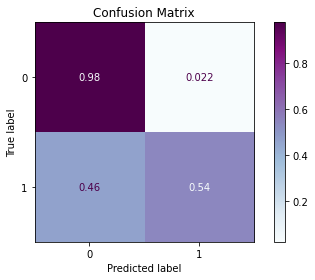

              precision    recall  f1-score   support

           0       0.83      0.98      0.90        90
           1       0.91      0.54      0.68        39

    accuracy                           0.84       129
   macro avg       0.87      0.76      0.79       129
weighted avg       0.86      0.84      0.83       129



In [54]:
report(X_test, y_test, predictions_lin, linmodel)

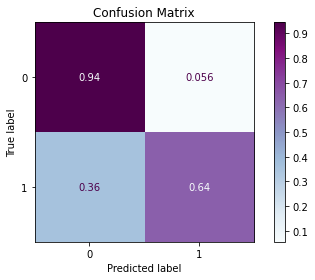

              precision    recall  f1-score   support

           0       0.86      0.94      0.90        90
           1       0.83      0.64      0.72        39

    accuracy                           0.85       129
   macro avg       0.85      0.79      0.81       129
weighted avg       0.85      0.85      0.85       129



In [55]:
report(X_test, y_test, predictions_log, logmodel)

Interpretation:

- The model has a higher precision (0.90) for class 0 (negative cases), meaning it rarely makes false positive predictions for non-preeclampsia cases.
- The recall for class 1 (positive cases) is lower (0.68), indicating the model might miss some actual preeclampsia cases (false negatives).
- The F1-score for both classes is around 0.6-0.8, suggesting a moderate balance between precision and recall.
- The overall accuracy of 81% is decent, but it's important to consider the context of the problem. Missing preeclampsia cases (low recall for class 1) might be more concerning than misclassifying non-preeclampsia cases (high precision for class 0).

Note: For explaination on `classification_report` look into [`Supplementary Content`](#classification-report) section.

# Best model

Although accuracy might not be the best measurement to assess [model performance](#classification-metrics) of this problem, given the time constrains, lets stick to that, and find the best performing model.

In [56]:
pd.DataFrame([test_results]).T.reset_index().rename(columns={
    'index': "Model",
    0: "Accuracy"
})

,Model,Accuracy
0,linear discriminant,0.898438
1,logistic discriminant,0.921875
2,sklearn_LR_liblinear,0.844961
3,sklearn_LR_lbfgs,0.844961


In [57]:
best_model: str = max(test_results, key=lambda item: item[1])
bold_print(
    f"Best model (by accuracy): `{best_model}`, with a score of: {test_results.get(best_model):.4f}"
)

Best model (by accuracy): `logistic discriminant`, with a score of: 0.9219

It seems like the from-scratch logistic regression model beats scikit-learn's `LogisticRegression` for the given metric (Accuracy)! 

*Take that info with a grain of salt. I will revisit this after the semester is over*. Being said that:

>> **This model is helpful for predicting pregnency risk**, which can be useful for early intervention.

# Potential Enhancements for Further Exploration

This section outlines potential avenues to refine the current analysis:

- Feature Engineering:

    * **Scaling:** Standardize or normalize features to ensure consistent contribution during model training.
    * **Outlier Handling:** Consider robust outlier removal techniques to address data inconsistencies, so that it conforms more to the [Logistic Regression preconditions](#logistic).
    * **Feature Creation:** Explore crafting new features to capture latent relationships within the data.
    * **Binning:** Discretize continuous features for models that perform better with categorical data.
    * **Dimensionality Reduction:** Utilize PCA to identify key underlying factors if dealing with high-dimensional data. This is are relative small dataset. still PCA can be useful to isolate most useful features


- Addressing Class Imbalance:

    * **Techniques:** Implement strategies like <b>oversampling</b> or <b>undersampling</b> to balance skewed class distributions.

- Alternative Models:

    * **Multinomial Logistic Regression:** Evaluate this model for multi-class classification tasks with interpretable coefficients.
    * **Random Forests (RF) & Support Vector Machines (SVM):** Explore these models for potential performance improvements based on data characteristics. (Observation size is too small for NeuralNet models IMHO)

Data enrichment is also a possibility (but highly unlikely):
- [gestational age](https://medlineplus.gov/ency/article/002367.htm#:~:text=Gestational%20age%20is%20the%20common,from%2038%20to%2042%20weeks.)  could be a important factor. 
- More features describing the observation will be useful for analysis, e.g. social determinents of health, medical and test reports (EHR records).

*Fin!*
___

# Supplementary Content

Contains explainers of some content mentioned in the analysis.

<a id='classification-metrics'></a>
## Classification Metrics:

- `Accuracy`: This is the overall percentage of correctly classified instances (both positive and negative cases). It's a good starting point, but it can be misleading in imbalanced datasets.

- `Precision`:  This metric represents the ratio of true positives (correctly predicted positive cases) to all predicted positive cases. It tells you how often the model predicted "positive" and it was actually correct. A high precision for a class is good, especially when dealing with the cost of misclassifying that class (e.g., false positives in medical diagnosis).

- `Recall`: This metric represents the ratio of true positives to all actual positive cases. It tells you how often the model identified all the actual positive cases (without missing any). A high recall is important when it's crucial to capture most of the positive cases (e.g., identifying fraudulent transactions).

- `F1-score`: This is the harmonic mean of precision and recall, combining their information into a single metric. A high F1-score indicates a good balance between precision and recall.

- `AUC-ROC` (Area Under the Receiver Operating Characteristic Curve):  This metric is particularly useful for imbalanced datasets. It measures the model's ability to distinguish between positive and negative cases. An AUC-ROC closer to 1 indicates better performance.

<a id='classification-report'></a>
## Classification report

Columns:

- `precision`: This represents the ratio of true positives (correctly predicted positive cases) to all predicted positive cases. In simpler terms, it tells you how often the model predicted "positive" and it was actually correct. A high precision for a class (e.g., class 0 in this case) means the model rarely makes false positive predictions for that class.
- `recall`: This represents the ratio of true positives to all actual positive cases. It tells you how often the model identified all the actual positive cases (without missing any). A high recall for a class means the model is good at capturing most of the actual positive cases.
- `f1-score`: This is a harmonic mean between precision and recall, combining their information into a single metric. A high F1-score indicates a good balance between precision and recall.
- `support`: This shows the total number of true instances for each class in the test data. In this case, there are 67 instances of class 0 and 19 instances of class 1.

Rows:

- `0 & 1`: These represent the two classes in your classification problem. The labels might not be explicitly mentioned here, but they should correspond to the class labels used during model training. In this case, we can assume class 0 represents negative cases and class 1 represents positive cases (based on the context of preeclampsia prediction).
- `accuracy`: This is the overall accuracy of the model, which is the percentage of correctly predicted cases across both classes. Here, the accuracy is 81%, meaning the model correctly classified 81% of the instances in the test data.
- `macro avg`: This is the average of the precision, recall, and F1-score across all classes, treating each class equally. Here, it provides a general overview of the model's performance.
- `weighted avg`: This is a weighted average of the precision, recall, and F1-score, where the weights are based on the number of instances in each class. It takes into account class imbalance if present.

## Logistic Regression preconditions:
<a id='logistic'></a>
- `Independent Observations`: Similar to regression, logistic regression also assumes independence of observations. This means the outcome for one observation shouldn't be influenced by the outcome of another.

- `Binary Dependent Variable`: Logistic regression is specifically designed for binary classification problems, where the dependent variable has only two categories (e.g., success/failure, alive/dead).

- `Linearity in the Logits`: While the relationship between the independent variables and the dependent variable (probability) isn't necessarily linear, logistic regression assumes a linear relationship between the independent variables and the log odds (logit) of the dependent variable. The logit transformation helps model the probability function.

- `No Perfect Separation`: The data shouldn't have a complete separation between the classes based on the independent variables. This means there shouldn't be a combination of independent variable values that perfectly predicts all observations to belong to one class or the other.

- `Large Enough Sample Size` (Especially for Rare Events):  Logistic regression can be sensitive to sample size, particularly when dealing with rare events (one of the classes has a very low proportion). A larger sample size helps ensure more reliable estimates of the model coefficients.


Click [Here](#top) to go to the beginning of the notebook.